All packages in the code block below needs to be installed for all functions in the notebook working appropriately.


In [39]:
import pandas as pd
import ipywidgets as widgets
import numpy as np
import time
import math
import os
import xlrd # install in user-environment on NERSC
import matplotlib.pyplot as plt
from datetime import datetime,date,time,timedelta
import matplotlib.dates as mdates
import base64

## 1. Data logger program

Data logger program is the program logger needs to make measurements, store data and do control. The frequency for data collection can be adjusted through the program. The logger programs that have been used are located in './thermistor_data/data logger program'

## 2. Specify logger information
There are six loggers in total and the IDs are 'A','B','C','D','E' and 'F', respectively. Each logger is associated with three thermistor rods and each thermistor rod has five or six thermistors. The information for the thermistor rod ID is in 'thermistor_data/logger_rod_IDs_for_python.csv'. Specify the logger that you are interested and also the data download date. The coordinates for each thermistor rod are put in 'thermistor_data/thermistor_coord.csv'.

The location map for the thermistor rods:
![Image](./misc/Thermal_rod_locations.png)

In [40]:
# Configure the logger to be processed
logger_name = 'C'          # Six loggers,'A','B','C','D','E' and 'F', in total
logger_loc_info = 'H3BA'     # the location info associated with the selected logger
download_date = '050119'   # download date
num_therm_per_logger = 15  # number of thermistors associated with the selected logger
num_rods_per_logger = 3    # number of thermistor rods associated with the selected logger

# Set the threshold values for the excitation voltage and converted resistance
low_thresh_exci = 195      # low threshold for the excitation voltage
high_thresh_exci = 205     # high threshold for the excitation voltage
low_thresh_res = 3600      # low threshold for the resistance
high_thresh_res = 32000    # high threshold for the resistance

# Set the path to the files  
cal_factor_file = "./thermistor_data/thermistor_linear_adjustment_output.xlsx" # calibration data for the thermistor
rodIDs_file = "./thermistor_data/logger_rod_IDs_for_python.csv" # rod ID information

# Column names in raw data file
header_in_rawdata = False # set True if the header exists in the raw data file. Otherwise, set False
rawdata_column_name = ['program_num','hours_from_year_start','mins_of_day','mvexcitation','mv1','mv2','mv3','mv4','mv5','mv6','mv7','mv8','mv9','mv10','mv11','mv12','mv13','mv14','mv15','mv16'] # set only if header_in_rawdata = False 



## 3. Raw data processing

### 3.1 Check voltage value


#### 3.1.1 Excitation voltage 
The applied excitation voltage is 200 milivolts. The points with excitation voltages lower than 195 milivolts or larger than 205 milivolt are considered as bad points and need to be removed. 

Start processing...
  The file for the raw data of logger C is found at ./thermistor_data/050119/Therm_C_final_storage_1_H3BA_050119.dat
  The file for the adjustment of thermistor is found at ./thermistor_data/thermistor_linear_adjustment_output.xlsx
  The file for the rod ID is found at ./thermistor_data/logger_rod_IDs_for_python.csv
  All necessary files are found. 

Start checking the excitation voltage...
  The time series of excitation voltage are: 


(737165.0, 737180.0)

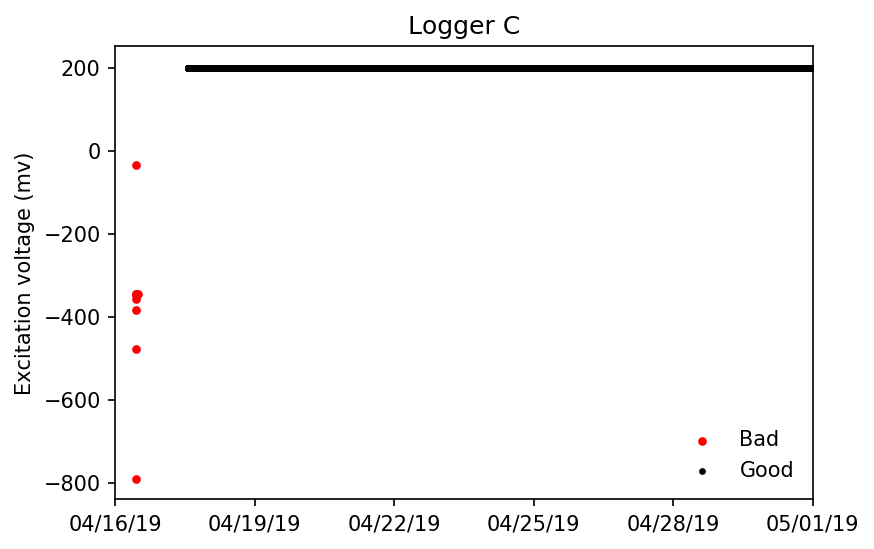

In [41]:
print('Start processing...')

cwd = os.getcwd()
rawdata_file = "./thermistor_data/"+download_date+'/Therm_'+logger_name+'_final_storage_1_'+logger_loc_info+'_'+download_date+'.dat'

try:
    with open(rawdata_file,'r') as f:
        print("  The file for the raw data of logger {} is found at {}".format(logger_name,rawdata_file))
    f.close()
except FileNotFoundError:
    print("  The file for the raw data of logger {} is not found".format(logger_name))   
    
try:
    with open(cal_factor_file,'r') as f:
        print("  The file for the adjustment of thermistor is found at {}".format(cal_factor_file))
    f.close()
except FileNotFoundError:
    print("  The file for thermistor rods location is not found")
    
try:
    with open(rodIDs_file,'r') as f:
        print("  The file for the rod ID is found at {}".format(rodIDs_file))
    f.close()
except FileNotFoundError:
    print("  The file for thermistor rods location is not found")



print("  All necessary files are found. \n".format(logger_name))  
#------------------------------------------------------------------------------
calfactors = pd.read_excel(cal_factor_file) 
rodIDs = pd.read_csv(rodIDs_file) 

if header_in_rawdata == False:
    rawdata = pd.read_csv(rawdata_file,header=None,names=rawdata_column_name)
else:
    rawdata = pd.read_csv(rawdata_file,header=0,names=rawdata_column_name)

print("Start checking the excitation voltage...".format(logger_name)) 
# visualize the good and bad excitation voltages. 
rawexci = rawdata[['hours_from_year_start','mins_of_day','mvexcitation']].values
goodexci = rawexci[:,-1].copy()
badexci = rawexci[:,-1].copy()
rawdatetimes = []

# convert hours_from_year_start and mins_of_dat to datetime
datetime_start = datetime(2019,1,1,0,0)
for i in range(rawexci.shape[0]):
    days = math.floor(int(rawexci[i,0])/24)
    times = int(rawexci[i,1])
    time = datetime_start + timedelta(days=days) + timedelta(minutes=times) 
    rawdatetimes.append(time)

goodexci[(goodexci>=high_thresh_exci) | (goodexci<=low_thresh_exci)] = np.nan
badexci[(badexci<high_thresh_exci) & (badexci>low_thresh_exci)] = np.nan

print("  The time series of excitation voltage are: ") 
fig,ax = plt.subplots(dpi=150)
line1 = plt.scatter(rawdatetimes,badexci,marker='o',c='r',s=10)
line2 = plt.scatter(rawdatetimes,goodexci,marker='o',c='k',s=5)

plt.ylabel('Excitation voltage (mv)')
plt.title("Logger {}".format(logger_name))
plt.legend((line1,line2),('Bad','Good'),frameon=False)
days_loc = mdates.DayLocator(interval=3)
days_fmt = mdates.DateFormatter('%m/%d/%y')
ax.xaxis.set_major_locator(days_loc)
ax.xaxis.set_major_formatter(days_fmt)

datemin = np.datetime64(rawdatetimes[0],'D')
datemax = np.datetime64(rawdatetimes[-1],'D')
ax.set_xlim(datemin,datemax)

#### 3.1.2 Remove the points with bad voltage

In [42]:
nan_idx = np.argwhere(np.isnan(goodexci))
exci=np.delete(rawexci[:,-1],nan_idx,0)
datetimes = np.delete(rawdatetimes,nan_idx,0)

column_name_volt = []
for i in range(num_therm_per_logger):
    column_name_volt.append('mv'+str(i+1))
volt = np.delete(rawdata[column_name_volt].values,nan_idx,0)
neg_idx = np.argwhere(volt[:,-1]<0)
volt = np.delete(volt,neg_idx,0)
exci = np.delete(exci,neg_idx,0)
datetimes = np.delete(datetimes,neg_idx,0)

print("The points with bad voltage have been removed")

The points with bad voltage have been removed


### 3.2 Convert voltage to temperature

There are three main steps in converting voltage to temperature:

Step 1: Convert voltage to resistance


Step 2: Calibrate resistance


Step 3: Convert calibrated resistance to temperature 




### 3.2.1. Convert voltage to resistance (step 1)

Resistance of the thermistor is sensitive to temperature change and needs to be calculated first at each time step. The calculation is based on Ohms law. Excitation voltage ($V_{eci}$) is applied as the source and the voltage ($V_{meas}$) for the resistor ($R_0$) with known resistance 10000 ohms is measured. The resistance for the thermistor is calculated by,

$$
\begin{align}
R_{therm}=R_{0}*(V_{eci}/V_{meas}-1)
\end{align}
$$

![Image](./misc/volt-ohms.png)

Step 1. Start converting the measured voltage to raw resistance...
        Converting the measured voltage to raw resistance done.
 


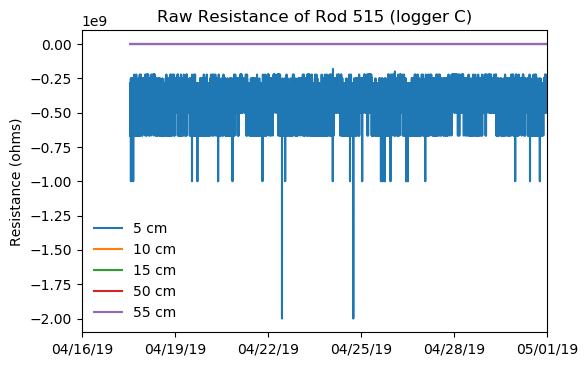

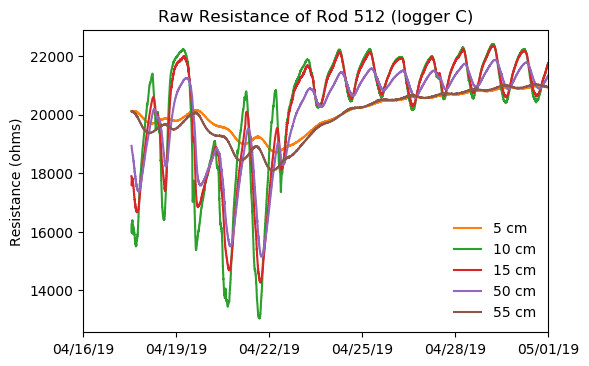

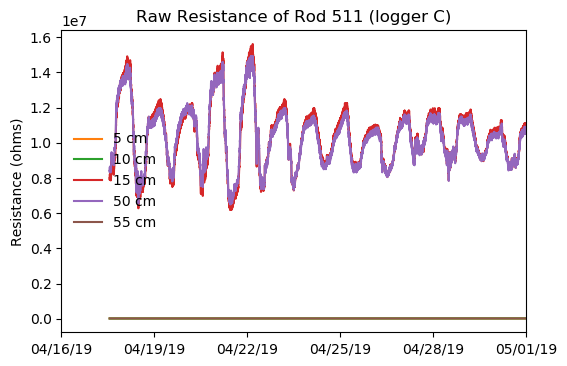

In [43]:
print("Step 1. Start converting the measured voltage to raw resistance...") 
rawres = 10000*(-1+np.divide(exci.reshape(-1,1),volt))
print("        Converting the measured voltage to raw resistance done.\n ")

rods = rodIDs.loc[rodIDs['loggerID']==logger_name]
rod1cal = calfactors.loc[calfactors['ID']==rods['rod 1'].iat[0]]
rod2cal = calfactors.loc[calfactors['ID']==rods['rod 2'].iat[0]]
rod3cal = calfactors.loc[calfactors['ID']==rods['rod 3'].iat[0]]
rodscal = rod1cal.append(rod2cal).append(rod3cal)

col = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(num_rods_per_logger):
    fig,ax = plt.subplots(dpi=100)
    leg = []
    lines = []
    if i == 0:
        idx = 0
        rod = rod1cal
    elif i == 1:
        idx = rod1cal.shape[0]
        rod = rod2cal
    elif i == 2:
        idx = rod1cal.shape[0] + rod2cal.shape[0]
        rod = rod3cal
    for j in range(rod.shape[0]):           
        if i == 0:
            line, = plt.plot(datetimes,rawres[:,j+idx],col[j])
        else:
            line, = plt.plot(datetimes,rawres[:,j+idx],col[j+1])
        lines.append(line)
        leg.append(str(rod['thermistor'].iat[j])+' cm')
        
        plt.ylabel('Resistance (ohms)')
        plt.title("Raw Resistance of Rod {} (logger {})".format(rod['ID'].iat[0],logger_name))
        plt.legend(lines,leg,frameon=False)
        days_loc = mdates.DayLocator(interval=3)
        days_fmt = mdates.DateFormatter('%m/%d/%y')
        ax.xaxis.set_major_locator(days_loc)
        ax.xaxis.set_major_formatter(days_fmt)

        datemin = np.datetime64(rawdatetimes[0],'D')
        datemax = np.datetime64(rawdatetimes[-1],'D')
        ax.set_xlim(datemin,datemax)
#        plt.savefig('thermistor_data/'+download_date+'_processed/figure/Rod{}_Logger{}_.png'.format(logger_name,rod['ID'].iat[0]),dpi=150)



        Start removing the raw resistance values that are larger than 32000 ohms or smaller than 3600 ohms...
        Bad points for raw resistance have been removed.

5
5
5


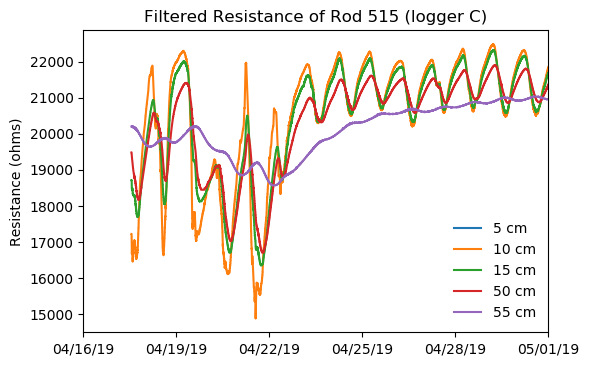

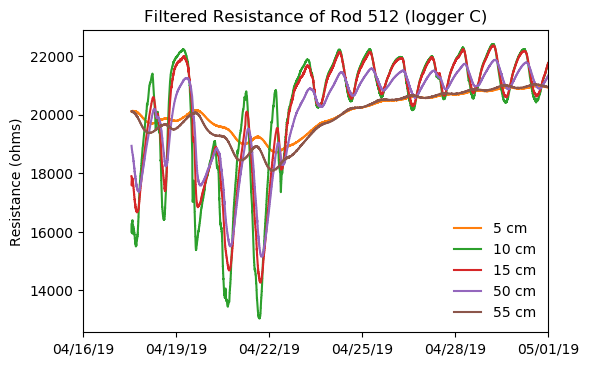

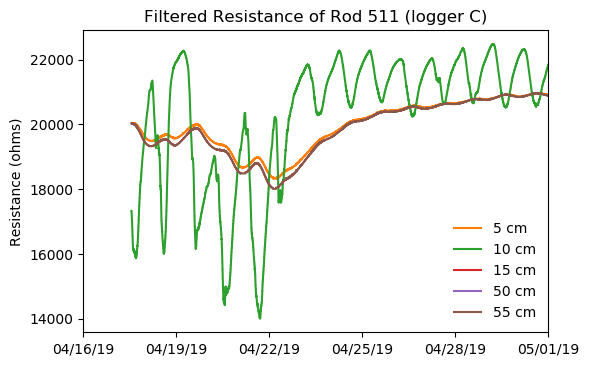

In [44]:
print("        Start removing the raw resistance values that are larger than {} ohms or smaller than {} ohms...".format(high_thresh_res,low_thresh_res)) 
rawres_filtered = rawres.copy()
rawres_filtered[(rawres_filtered>high_thresh_res) | (rawres_filtered<low_thresh_res)] = np.nan
print("        Bad points for raw resistance have been removed.\n")

for i in range(num_rods_per_logger):
    fig,ax = plt.subplots(dpi=100)
    leg = []
    lines = []
    if i == 0:
        idx = 0
        rod = rod1cal
    elif i == 1:
        idx = rod1cal.shape[0]
        rod = rod2cal
    elif i == 2:
        idx = rod1cal.shape[0] + rod2cal.shape[0]
        rod = rod3cal
    print(rod.shape[0])
    for j in range(rod.shape[0]):  
        if i == 0:
            line, = plt.plot(datetimes,rawres_filtered[:,j+idx],col[j])
        else:
            line, = plt.plot(datetimes,rawres_filtered[:,j+idx],col[j+1])
        lines.append(line)
        leg.append(str(rod['thermistor'].iat[j])+' cm')
        
        plt.ylabel('Resistance (ohms)')
        plt.title("Filtered Resistance of Rod {} (logger {})".format(rod['ID'].iat[0],logger_name))
        plt.legend(lines,leg,frameon=False)
        days_loc = mdates.DayLocator(interval=3)
        days_fmt = mdates.DateFormatter('%m/%d/%y')
        ax.xaxis.set_major_locator(days_loc)
        ax.xaxis.set_major_formatter(days_fmt)

        datemin = np.datetime64(rawdatetimes[0],'D')
        datemax = np.datetime64(rawdatetimes[-1],'D')
        ax.set_xlim(datemin,datemax)
#        plt.savefig('thermistor_data/'+download_date+'_processed/figure/Rod{}_Logger{}_.png'.format(logger_name,rod['ID'].iat[0]),dpi=150)

### 3.2.2. Calibrate resistance (step 2)

The calcualted resistance at first step needs to be adjusted by a linear function. The slope and intercept of the linear function are obtained by experiments for each thermistor.

$$
\begin{align}
R_{therm\_adjusted} = k*R_{therm}+a_{0}
\end{align}
$$

where $k$ is the slope and $a_{0}$ is the intercept.

Step 2. Start calibrating the raw resistance...
        Calibration of raw resistance done.



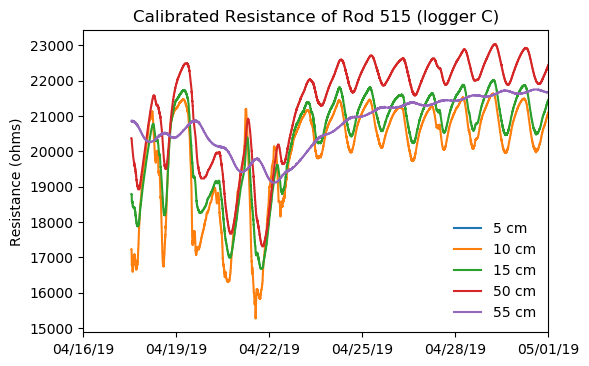

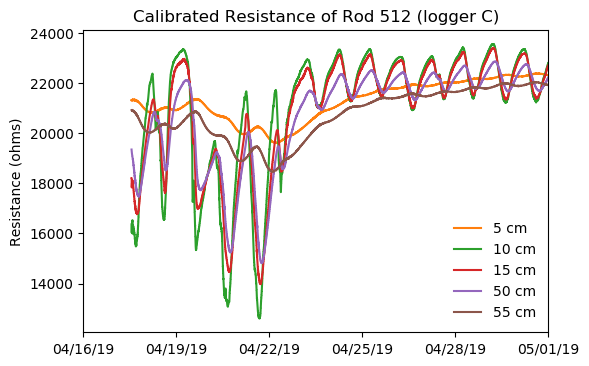

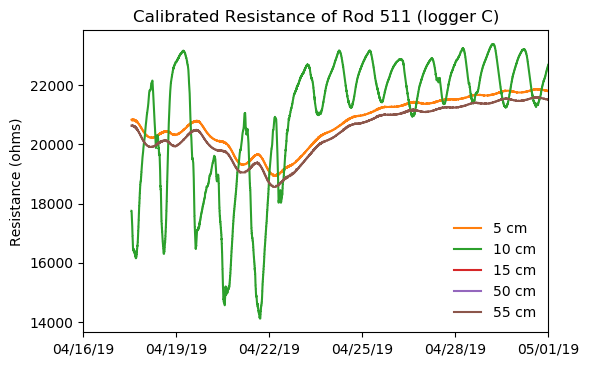

In [45]:
print("Step 2. Start calibrating the raw resistance...") 
calres = np.multiply(rawres_filtered,np.transpose(rodscal['ohmslope'].values))+np.transpose(rodscal['ohmyint'].values)
print("        Calibration of raw resistance done.\n")

for i in range(num_rods_per_logger):
    fig,ax = plt.subplots(dpi=100)
    leg = []
    lines = []
    if i == 0:
        idx = 0
        rod = rod1cal
    elif i == 1:
        idx = rod1cal.shape[0]
        rod = rod2cal
    elif i == 2:
        idx = rod1cal.shape[0] + rod2cal.shape[0]
        rod = rod3cal
    for j in range(rod.shape[0]):  
        if i == 0:
            line, = plt.plot(datetimes,calres[:,j+idx],col[j])
        else:
            line, = plt.plot(datetimes,calres[:,j+idx],col[j+1])
        lines.append(line)
        leg.append(str(rod['thermistor'].iat[j])+' cm')
        
        plt.ylabel('Resistance (ohms)')
        plt.title("Calibrated Resistance of Rod {} (logger {})".format(rod['ID'].iat[0],logger_name))
        plt.legend(lines,leg,frameon=False)
        days_loc = mdates.DayLocator(interval=3)
        days_fmt = mdates.DateFormatter('%m/%d/%y')
        ax.xaxis.set_major_locator(days_loc)
        ax.xaxis.set_major_formatter(days_fmt)

        datemin = np.datetime64(rawdatetimes[0],'D')
        datemax = np.datetime64(rawdatetimes[-1],'D')
        ax.set_xlim(datemin,datemax)

### 3.2.3 Convert calibrate resistance to temperature (step 3)

The relation between the adjusted thermistor resistance and temperature is provided by the technical documents,

$$
\begin{align}
T=-22.67*log(R_{therm\_adjusted})+234.43
\end{align}
$$

Step 3. Start converting the calibrated resistance to temperature...
        Converting the calibrated resistance to temperature done.



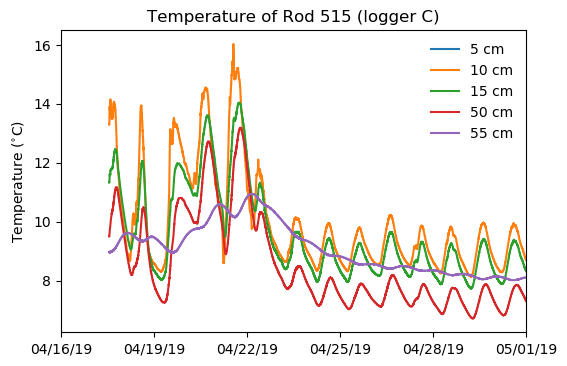

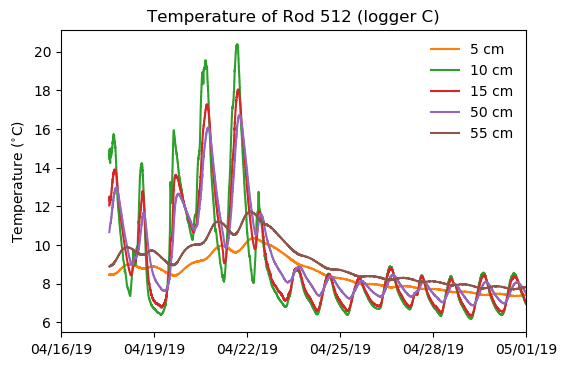

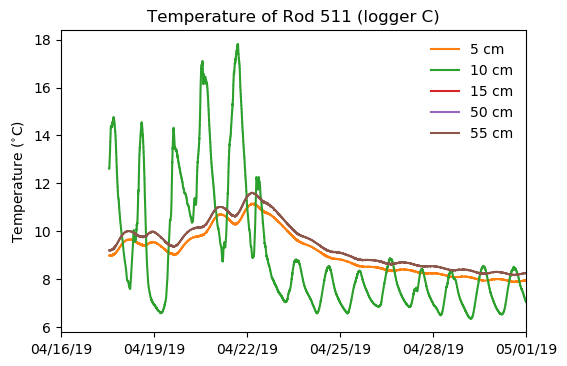

In [46]:
print("Step 3. Start converting the calibrated resistance to temperature...") 
temp = -22.67*np.log(calres)+234.43
print("        Converting the calibrated resistance to temperature done.\n")

for i in range(num_rods_per_logger):
    fig,ax = plt.subplots(dpi=100)
    leg = []
    lines = []
    if i == 0:
        idx = 0
        rod = rod1cal
    elif i == 1:
        idx = rod1cal.shape[0]
        rod = rod2cal
    elif i == 2:
        idx = rod1cal.shape[0] + rod2cal.shape[0]
        rod = rod3cal
    for j in range(rod.shape[0]):   
        if i == 0:
            line, = plt.plot(datetimes,temp[:,j+idx],col[j])
        else:
            line, = plt.plot(datetimes,temp[:,j+idx],col[j+1])
        lines.append(line)
        leg.append(str(rod['thermistor'].iat[j])+' cm')
        
        plt.ylabel('Temperature ($^{\circ}$C)')
        plt.title("Temperature of Rod {} (logger {})".format(rod['ID'].iat[0],logger_name))
        plt.legend(lines,leg,frameon=False)
        days_loc = mdates.DayLocator(interval=3)
        days_fmt = mdates.DateFormatter('%m/%d/%y')
        ax.xaxis.set_major_locator(days_loc)
        ax.xaxis.set_major_formatter(days_fmt)

        datemin = np.datetime64(rawdatetimes[0],'D')
        datemax = np.datetime64(rawdatetimes[-1],'D')
        ax.set_xlim(datemin,datemax)
        plt.savefig('thermistor_data/'+download_date+'_processed/figure/rod{}_logger{}.png'.format(rod['ID'].iat[0],logger_name),dpi=150)

### 3.3 Filter out the temperature outliers

If obvious outliers for tempreature are observed, run the moving average filter below to remove the outliers. Otherwise, this part can be skipped.

In [47]:
temp_filter = True

def moving_average_filter(data,window,coef,data_resolution):
    data_filtered = data.copy()
    data_removed = data.copy()
    step = math.floor(window*24*3600/data_resolution)
    for i in range(data.shape[1]):
        x = data[:,i]
        for j in range(len(x)):
            if j < len(x)-step:
                x1 = [i for i in x[j:j+step] if i > 0]
            else:
                x1 = [i for i in x[j:] if i > 0]
                
            if len(x1) == 0:
                continue
            
            x1 = [xx for xx in x1 if str(xx) != 'nan']
            mean = np.mean(x1)
            sd = np.std(x1)
            if (x[j] <= mean+coef*sd and x[j] >= mean-coef*sd):
                data_filtered[j,i] = x[j]
                data_removed[j,i] = np.nan
            else:
                data_filtered[j,i] = np.nan
                data_removed[j,i] = x[j]
    
    return data_filtered,data_removed

# temp_filtered,temp_removed = moving_average_filter(temp,window=3,coef=6,data_resolution=60)

# for i in range(num_rods_per_logger):
#     fig,ax = plt.subplots(dpi=100)
#     leg = []
#     lines = []
#     if i == 0:
#         idx = 0
#         rod = rod1cal
#     elif i == 1:
#         idx = rod1cal.shape[0]
#         rod = rod2cal
#     elif i == 2:
#         idx = rod1cal.shape[0] + rod2cal.shape[0]
#         rod = rod3cal
#     for j in range(rod.shape[0]):           
#         line, = plt.plot(datetimes,temp_filtered[:,j+idx])
#         lines.append(line)
#         leg.append(str(rod['thermistor'].iat[j])+' cm')
        
#         plt.ylabel('Temperature ($^{\circ}$C)')
#         plt.title("Filtered Temperature of Rod {} (logger {})".format(rod['ID'].iat[0],logger_name))
#         plt.legend(lines,leg,frameon=False)
#         days_loc = mdates.DayLocator(interval=3)
#         days_fmt = mdates.DateFormatter('%m/%d/%y')
#         ax.xaxis.set_major_locator(days_loc)
#         ax.xaxis.set_major_formatter(days_fmt)

#         datemin = np.datetime64(rawdatetimes[0],'D')
#         datemax = np.datetime64(rawdatetimes[-1],'D')
#         ax.set_xlim(datemin,datemax)
#         plt.savefig('thermistor_data/'+download_date+'_processed/figure/rod{}_logger{}_filtered.png'.format(logger_name,rod['ID'].iat[0]),dpi=150)
        
#         line, = plt.plot(datetimes,temp_removed[:,j+idx],'*')
#         lines.append(line)
#         leg.append(str(rod['thermistor'].iat[j])+' cm(removed)')
        
#         plt.ylabel('Temperature ($^{\circ}$C)')
#         plt.title("Removed Temperature of Rod {} (logger {})".format(rod['ID'].iat[0],logger_name))
#         plt.legend(lines,leg,frameon=False)
#         days_loc = mdates.DayLocator(interval=3)
#         days_fmt = mdates.DateFormatter('%m/%d/%y')
#         ax.xaxis.set_major_locator(days_loc)
#         ax.xaxis.set_major_formatter(days_fmt)

#         datemin = np.datetime64(rawdatetimes[0],'D')
#         datemax = np.datetime64(rawdatetimes[-1],'D')
#         ax.set_xlim(datemin,datemax)
        

## 4. Export temperature data

The converted raw temperature and filtered temperature if available are exported for each rod.

In [48]:
rodscal = [rod1cal,rod2cal,rod3cal]
temp_filter = False

for idx,val in enumerate(rodscal):
    column_name = ['Datetime']  
    for j in range(val.shape[0]):
        column_name.append(str(val['thermistor'].iat[j])+'cm')
    if idx == 0:
        output = np.concatenate((datetimes.reshape(-1,1),temp[:,:rod1cal.shape[0]]),axis=1)
    if idx == 1:
        output = np.concatenate((datetimes.reshape(-1,1),temp[:,rod1cal.shape[0]:(rod1cal.shape[0]+rod2cal.shape[0])]),axis=1)
    if idx == 2:
        output = np.concatenate((datetimes.reshape(-1,1),temp[:,(rod1cal.shape[0]+rod2cal.shape[0]):]),axis=1)
    filename=('./thermistor_data/'+download_date+'_processed/temperature_rod{}_logger{}_raw.csv'.format(val['ID'].iat[0],logger_name))
    np.savetxt(filename,output,delimiter=',',header=','.join(column_name),fmt="%s")

if temp_filter:
    for idx,val in enumerate(rodscal):
        column_name = ['Datetime']  
        for j in range(val.shape[0]):
            column_name.append(str(val['thermistor'].iat[j])+'cm')
        if idx == 0:
            output = np.concatenate((datetimes.reshape(-1,1),temp_filtered[:,:rod1cal.shape[0]]),axis=1)
        if idx == 1:
            output = np.concatenate((datetimes.reshape(-1,1),temp_filtered[:,rod1cal.shape[0]:(rod1cal.shape[0]+rod2cal.shape[0])]),axis=1)
        if idx == 2:
            output = np.concatenate((datetimes.reshape(-1,1),temp_filtered[:,(rod1cal.shape[0]+rod2cal.shape[0]):]),axis=1)
        filename=('./thermistor_data/'+download_date+'_processed/temperature_rod{}_logger{}_filtered.csv'.format(val['ID'].iat[0],logger_name))
        np.savetxt(filename,output,delimiter=',',header=','.join(column_name),fmt="%s")
       
            

print('The processed data are located at:'+'./thermistor_data/'+download_date+'_processed/')
print('processing complete')


The processed data are located at:./thermistor_data/050119_processed/
processing complete
